<table style="border: none" align="left">
   <tr style="border: none">
      <th style="border: none"><font face="verdana" size="4" color="black"><b>From tensorflow experiment to scoring with</b></font><font face="monospace" size="4" color="darkblue"><b> watson-machine-learning-client</b></font></th>
      <th style="border: none"><img src="https://github.com/pmservice/customer-satisfaction-prediction/blob/master/app/static/images/ml_icon_gray.png?raw=true" alt="Watson Machine Learning icon" height="40" width="40"></th>
   </tr> 
   <tr style="border: none">
       <td style="border: none"><img src="https://github.com/pmservice/wml-sample-models/raw/master/tensorflow/hand-written-digit-recognition/images/experiment_banner.png" width="800" alt="Icon"></td>
   </tr>
</table>

This notebook contains steps and code to demonstrate support of Deep Learning model training and scoring in Watson Machine Learning Service. This notebook introduces commands for getting data, training_definition persistance to Watson Machine Learning repository, model training, model persistance, model deployment and scoring.

Some familiarity with Python is helpful. This notebook uses Python 3.


## Learning goals

The learning goals of this notebook are:

-  Working with Watson Machine Learning experiments to train Deep Learning models (TensorFlow).
-  Saving trained models in Watson Machine Learning repository.
-  Online deployment and scoring of trained model.


## Contents

This notebook contains the following parts:

1.	[Setup](#setup)
2.	[Training definition](#definition)
3.	[Experiment definition](#experiment)
4.	[Experiment Run](#run)
5.	[Deploy and Score](#scoring)
6.	[Summary and next steps](#summary)

<a id="setup"></a>
## 1. Setup

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Create a [Watson Machine Learning Service](https://console.ng.bluemix.net/catalog/services/ibm-watson-machine-learning/) instance (a lite plan is offered). 
-  Create [Cloud Object Storage (COS)](https://console.bluemix.net/catalog/infrastructure/cloud-object-storage) instance (a lite plan is offered).
    - After you create COS instance, go to your COS dashboard.
    - In "Service credentials" tab, click on "New Credential",
    - Add inline configuration parameter: {"HMAC":true}, click "Add".

    This configuration parameter will add section below to instance credentials which will be used later on,
    ```
      "cos_hmac_keys": {
            "access_key_id": "722432c254bc4eaa96e05897bf2779e2",
            "secret_access_key": "286965ac10ecd4de8b44306288c7f5a3e3cf81976a03075c"
       }
    ```

### 1.1 Working with Cloud Object Storage

Boto library allows Python developers to manage Cloud Object Storage.

In [14]:
import ibm_boto3
from ibm_botocore.client import Config
import os, json, warnings

We define the endpoint we will use. You can find this information in "Endpoint" section of your Cloud Object Storage intance's dashbord.

In [2]:
cos_credentials = {
  "apikey": "***",
  "cos_hmac_keys": {
    "access_key_id": "***",
    "secret_access_key": "***"
  },
  "endpoints": "https://cos-service.bluemix.net/endpoints",
  "iam_apikey_description": "***",
  "iam_apikey_name": "***",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "***",
  "resource_instance_id": "***"
}

api_key = cos_credentials['apikey']
service_instance_id = cos_credentials['resource_instance_id']
auth_endpoint = 'https://iam.bluemix.net/oidc/token'
service_endpoint = 'https://s3-api.us-geo.objectstorage.softlayer.net'

In [15]:
# The code was removed by DSX for sharing.

We create Boto resource by providing type, endpoint_url and credentials.

In [16]:
cos = ibm_boto3.resource('s3',
                         ibm_api_key_id=api_key,
                         ibm_service_instance_id=service_instance_id,
                         ibm_auth_endpoint=auth_endpoint,
                         config=Config(signature_version='oauth'),
                         endpoint_url=service_endpoint)

Let's create the buckets we will use to store training data and training results.

In [15]:
import datetime

date_time = datetime.datetime.now()
date_time = date_time.strftime("%Y-%m-%d-%H-%M")

buckets = {'data': 'train-data-experiment-' + date_time, 'results': 'train-result-experiment-' + date_time}

for bucket in buckets.values():
    if not cos.Bucket(bucket) in cos.buckets.all():
        print('Creating bucket "{}"...'.format(bucket))
        try:
            cos.create_bucket(Bucket=bucket)
        except ibm_boto3.exceptions.ibm_botocore.client.ClientError as e:
            print('Error: {}.'.format(e.response['Error']['Message']))
    else:
        print('Bucket "{}" already exists.'.format(bucket))

Creating bucket "train-data-experiment-2018-03-28-09-34"...
Creating bucket "train-result-experiment-2018-03-28-09-34"...


Now we should have 2 new buckets created.

### 1.2 Downloading training data and upload it to COS buckets.

Let's download our training data and upload them to 'training-data' bucket.
We will create a list of links for training dataset

In [20]:
data_links = ['http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
              'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
              'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
              'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz']

Below snippet will create 'MNIST_DATA' folder and download the files from links.

**Tip:** First, please install wget library by the command below
`!pip install wget`

In [21]:
import wget, glob

data_dir = 'MNIST_DATA'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

for link in data_links:
    if not os.path.isfile(os.path.join(data_dir, os.path.join(link.split('/')[-1]))):
        wget.download(link, out=data_dir)

glob.glob('MNIST_DATA/*')

['MNIST_DATA/train-labels-idx1-ubyte.gz',
 'MNIST_DATA/t10k-labels-idx1-ubyte.gz',
 'MNIST_DATA/train-images-idx3-ubyte.gz',
 'MNIST_DATA/t10k-images-idx3-ubyte.gz']

Upload the data files to created buckets.

In [18]:
bucket_name = buckets['data']
bucket_obj = cos.Bucket(bucket_name)

for filename in os.listdir(data_dir):
    with open(os.path.join(data_dir, filename), 'rb') as data: 
        bucket_obj.upload_file(os.path.join(data_dir, filename), filename)
        print('{} is uploaded.'.format(filename))

train-labels-idx1-ubyte.gz is uploaded.
t10k-labels-idx1-ubyte.gz is uploaded.
train-images-idx3-ubyte.gz is uploaded.
t10k-images-idx3-ubyte.gz is uploaded.


Let's see the list of created buckets and their contents.

In [19]:
for obj in bucket_obj.objects.all():
    print('Object key: {}, size: {:5.1f}kB'.format(obj.key, obj.size/1024))

Object key: t10k-images-idx3-ubyte.gz, size: 1610.2kB
Object key: t10k-labels-idx1-ubyte.gz, size:   4.4kB
Object key: train-images-idx3-ubyte.gz, size: 9680.1kB
Object key: train-labels-idx1-ubyte.gz, size:  28.2kB


We are done with Cloud Object Storage, we are ready to train our model!

### 1.3 Work with the Watson Machine Learning instance

Authenticate to Watson Machine Learning service on Bluemix.

**Action**: Put authentication information from your instance of Watson Machine Learning service here.

In [20]:
wml_credentials = {
  "url": "https://ibm-watson-ml.mybluemix.net",
  "access_key": "***",
  "username": "***",
  "password": "***",
  "instance_id": "***"
}

In [6]:
# The code was removed by DSX for sharing.

#### Install `watson-machine-learning-client` from pypi

In [7]:
!rm -rf $PIP_BUILD/watson-machine-learning-client

In [8]:
!pip install --upgrade watson-machine-learning-client --upgrade

Requirement already up-to-date: watson-machine-learning-client in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages
Requirement not upgraded as not directly required: requests in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement not upgraded as not directly required: lomond in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement not upgraded as not directly required: urllib3 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement not upgraded as not directly required: pandas in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement not upgraded as not directly required: tabulate in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement not upgraded as not directly required: certifi in /opt/conda/envs/DSX-Python35/l

#### Import `watson-machine-learning-client` and authenticate to service instance

In [9]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

In [10]:
client = WatsonMachineLearningAPIClient(wml_credentials)

In [11]:
print(client.version)

1.0.53


**Note:** `watson-machine-learning-client` documentation can be found here [http://wml-api-pyclient.mybluemix.net/](http://wml-api-pyclient.mybluemix.net/).

<a id="definition"></a>
## 2. Training definitions

### 2.2 Save training definition 

#### Prepare training definition metadata

In [9]:
model_definition_tf_metadata = {
            client.repository.DefinitionMetaNames.NAME: "Tensorflow - distributed",
            client.repository.DefinitionMetaNames.AUTHOR_EMAIL: "lc@pl.ibm.com",
            client.repository.DefinitionMetaNames.FRAMEWORK_NAME: "tensorflow",
            client.repository.DefinitionMetaNames.FRAMEWORK_VERSION: "1.5",
            client.repository.DefinitionMetaNames.RUNTIME_NAME: "python",
            client.repository.DefinitionMetaNames.RUNTIME_VERSION: "3.5",
            client.repository.DefinitionMetaNames.EXECUTION_COMMAND: "PS_HOSTS_COUNT=1 ./launcher.py python3 ${MODEL_DIR}/mnist_dist.py --data_dir ${DATA_DIR}"
            }

In [10]:
model_definition_horovod_metadata = {
            client.repository.DefinitionMetaNames.NAME: "Tensorflow - horovod",
            client.repository.DefinitionMetaNames.AUTHOR_EMAIL: "lc@pl.ibm.com",
            client.repository.DefinitionMetaNames.FRAMEWORK_NAME: "tensorflow-horovod",
            client.repository.DefinitionMetaNames.FRAMEWORK_VERSION: "1.5",
            client.repository.DefinitionMetaNames.RUNTIME_NAME: "python",
            client.repository.DefinitionMetaNames.RUNTIME_VERSION: "3.5",
            client.repository.DefinitionMetaNames.EXECUTION_COMMAND: "python tensorflow_mnist.py"
            }

In [11]:
model_definition_ddl_metadata = {
            client.repository.DefinitionMetaNames.NAME: "Tensorflow - ddl",
            client.repository.DefinitionMetaNames.AUTHOR_EMAIL: "lc@pl.ibm.com",
            client.repository.DefinitionMetaNames.FRAMEWORK_NAME: "tensorflow-ddl",
            client.repository.DefinitionMetaNames.FRAMEWORK_VERSION: "1.5",
            client.repository.DefinitionMetaNames.RUNTIME_NAME: "python",
            client.repository.DefinitionMetaNames.RUNTIME_VERSION: "3.5",
            client.repository.DefinitionMetaNames.EXECUTION_COMMAND: "python mnist-train-ddl.py; python transform.py"
            }

#### Get sample model definition content files from git

In [22]:
filename_tf = 'tf_distributed.zip'
filename_horovod = 'tf_horovod.zip'
filename_ddl = 'tf_ddl.zip'

if os.path.isfile(filename_tf):
    os.remove(filename_tf)
wget.download('https://github.com/pmservice/wml-sample-models/raw/master/tensorflow/distributed-hand-written-digits/native/' + filename_tf)

if os.path.isfile(filename_horovod):
    os.remove(filename_horovod)
wget.download('https://github.com/pmservice/wml-sample-models/raw/master/tensorflow/distributed-hand-written-digits/horovod/' + filename_horovod)

if os.path.isfile(filename_ddl):
    os.remove(filename_ddl)
wget.download('https://github.com/pmservice/wml-sample-models/raw/master/tensorflow/distributed-hand-written-digits/ddl/' + filename_ddl)

glob.glob('tf_*.zip')

['tf_horovod.zip', 'tf_ddl.zip', 'tf_distributed.zip']

#### Publish training definition in Watson Machine Learning repository

##### Store definition: native distributed tensorflow

In [23]:
definition_tf_details = client.repository.store_definition(filename_tf, model_definition_tf_metadata)

definition_tf_url = client.repository.get_definition_url(definition_tf_details)
definition_tf_uid = client.repository.get_definition_uid(definition_tf_details)
print(definition_tf_url)

https://ibm-watson-ml.mybluemix.net/v3/ml_assets/training_definitions/06fa6000-9b1b-4cf0-8932-f35cf449361e


##### Store definition: horovod

In [24]:
definition_horovod_details = client.repository.store_definition(filename_horovod, model_definition_horovod_metadata)

definition_horovod_url = client.repository.get_definition_url(definition_horovod_details)
definition_horovod_uid = client.repository.get_definition_uid(definition_horovod_details)
print(definition_horovod_url)

https://ibm-watson-ml.mybluemix.net/v3/ml_assets/training_definitions/a473639d-4280-4157-b360-7df30f965788


##### Store definition: ibm DDL

In [25]:
definition_ddl_details = client.repository.store_definition(filename_ddl, model_definition_ddl_metadata)

definition_ddl_url = client.repository.get_definition_url(definition_ddl_details)
definition_ddl_uid = client.repository.get_definition_uid(definition_ddl_details)
print(definition_ddl_url)

https://ibm-watson-ml.mybluemix.net/v3/ml_assets/training_definitions/c5988360-4241-4565-8e6c-05fde3c8b27e


#### LIST stored definitions

In [26]:
client.repository.list_definitions()

------------------------------------  ----------------------------------------  ------------------------  ------------------
GUID                                  NAME                                      CREATED                   FRAMEWORK
ea8c0dd5-8a6b-4e5e-a9cd-74a0c573c1de  MNIST-MLP                                 2018-03-15T10:20:58.646Z  tensorflow
8095a87c-5c94-4f43-b5fd-468b2d72a3c8  MNIST-CNN                                 2018-03-15T10:21:00.033Z  tensorflow
bebc485e-bcc9-45b7-9bce-1ba20acc3b53  MNIST-MLP                                 2018-03-15T10:35:04.997Z  tensorflow
f26539ff-43b5-4100-8915-7b0be22b2211  MNIST-CNN                                 2018-03-15T10:35:05.815Z  tensorflow
bed45da1-6372-4cb1-b889-e0d402cfe62a  MNIST-MLP                                 2018-03-15T15:41:40.335Z  tensorflow
c80aaeef-1c03-4474-8891-535aa6dae81e  MNIST-CNN                                 2018-03-15T15:41:41.174Z  tensorflow
f819f724-8e1c-4903-a04c-eee5dfc048a4  style transfer van 

<a id="experiment"></a>
## 3. Experiment definition

### 3.1 Save experiment

#### Get the list of supported configuration params

In [27]:
client.repository.ExperimentMetaNames.show()

--------------------------  ----  --------
META_PROP NAME              TYPE  REQUIRED
NAME                        str   Y
TAGS                        list  N
DESCRIPTION                 str   N
AUTHOR_NAME                 str   N
AUTHOR_EMAIL                str   Y
EVALUATION_METHOD           str   N
EVALUATION_METRICS          list  N
TRAINING_REFERENCES         list  Y
TRAINING_DATA_REFERENCE     dict  Y
TRAINING_RESULTS_REFERENCE  dict  Y
--------------------------  ----  --------


#### Experiment configuration dictionary
Create experiment that will train two models based on previously stored definitions.

In [29]:
TRAINING_DATA_REFERENCE = {
                            "connection": {
                                "endpoint_url": service_endpoint,
                                "access_key_id": cos_credentials['cos_hmac_keys']['access_key_id'],
                                "secret_access_key": cos_credentials['cos_hmac_keys']['secret_access_key']
                            },
                            "source": {
                                "bucket": buckets[0],
                            },
                            "type": "s3"
                           }
TRAINING_RESULTS_REFERENCE = {
                                "connection": {
                                    "endpoint_url": service_endpoint,
                                    "access_key_id": cos_credentials['cos_hmac_keys']['access_key_id'],
                                    "secret_access_key": cos_credentials['cos_hmac_keys']['secret_access_key']
                                },
                                "target": {
                                    "bucket": buckets[1],
                                },
                                "type": "s3"
                             }

In [30]:
experiment_metadata = {
            client.repository.ExperimentMetaNames.NAME: "Distributed MNIST experiment",
            client.repository.ExperimentMetaNames.AUTHOR_EMAIL: "lc@pl.ibm.com",
            client.repository.ExperimentMetaNames.TRAINING_DATA_REFERENCE: TRAINING_DATA_REFERENCE,
            client.repository.ExperimentMetaNames.TRAINING_RESULTS_REFERENCE: TRAINING_RESULTS_REFERENCE,
            client.repository.ExperimentMetaNames.TRAINING_REFERENCES: [
                        {
                            "name": "tf-distributed",
                            "training_definition_url": definition_tf_url,
                            "compute_configuration": {"name": "p100", "nodes": 2}
                        },                        
                        {
                            "name": "tf-horovod",
                            "training_definition_url": definition_horovod_url,
                            "compute_configuration": {"name": "p100", "nodes": 2}
                        },                        
                        {
                            "name": "tf-ddl",
                            "training_definition_url": definition_ddl_url,
                            "compute_configuration": {"name": "p100", "nodes": 2}
                        }
                    ],
                }

#### Store experiment in Watson Machine Learning repository

In [31]:
experiment_details = client.repository.store_experiment(meta_props=experiment_metadata)

experiment_uid = client.repository.get_experiment_uid(experiment_details)
print(experiment_uid)

d763b2eb-1b9d-440e-8c25-09a0f06ee017


#### LIST stored experiments

In [32]:
client.repository.list_experiments()

------------------------------------  ----------------------------  ------------------------
GUID                                  NAME                          CREATED
0c8803bf-122f-4066-be77-39d6aef4de3d  MNIST experiment              2018-03-15T10:35:54.116Z
207928e4-2634-48b2-80d1-acbc3eed3db2  MNIST experiment              2018-03-15T10:21:23.857Z
298cc42b-3138-43a2-a690-bf18292e7f65  STYLE experiment              2018-03-16T10:34:03.736Z
3b274502-a203-430f-b2b2-903f1e713d40  MNIST experiment              2018-03-16T10:00:46.078Z
496a28ea-7887-4b3e-b4c0-28d21b831333  MNIST experiment              2018-03-15T15:41:47.219Z
4bae6fcb-f490-45b7-bdaf-559030b6a0f9  STYLE experiment              2018-03-15T21:46:05.795Z
ceb102b9-a05a-4e42-8212-4ac1e0fe115e  STYLE experiment              2018-03-16T08:37:30.628Z
d763b2eb-1b9d-440e-8c25-09a0f06ee017  Distributed MNIST experiment  2018-03-28T09:46:25.089Z
d8cf0def-3a2c-4cee-83b9-79b5eedff2eb  STYLE experiment              2018-03-15T20:57:23

#### UPDATE experiment
You can update experiment definition by calling below method.

#### GET experiment definition details

In [33]:
details = client.repository.get_experiment_details(experiment_uid)

#### Delete experiment definition from repository

<a id="run"></a>
## 4. Run experiment

### 4.1 Run experiment

**Tip:** To run experiment in background set optional parameter `asynchrounous=True` (or remove it)

In [35]:
experiment_run_details = client.experiments.run(experiment_uid, asynchronous=False)



#############################################################

Running '5abc65a2-0ab4-480b-a356-23bea3442d3c' experiment run

#############################################################




--------------------------------------------------------------------
Run of '5abc65a2-0ab4-480b-a356-23bea3442d3c' finished successfully.
--------------------------------------------------------------------




As we can see experiment run has fininshed.

#### GET experiment run UID

In [13]:
experiment_run_id = client.experiments.get_run_uid(experiment_run_details)
print(experiment_run_id)

98590d53-c70a-470c-8fde-dcb017a8dfaf


#### GET experiment details
Use below method to get all information about particular experiment.

In [16]:
experiment_details = client.experiments.get_details(experiment_uid)

You can use below print method to display experiment details (change cell type to code).

#### GET run details
Use below method to get particular experiment run details.

In [17]:
run_details = client.experiments.get_run_details(experiment_run_id)

#### GET experiment run status
You can check experiment run status by calling `client.experiments.get_status(run_uid)` method. This is quite useful when running experiment in background.

In [18]:
status = client.experiments.get_status(experiment_run_id)
print(status)

{'current_iteration': 1, 'submitted_at': '2018-03-28T10:08:02Z', 'state': 'completed', 'current_at': '2018-03-28T10:08:02Z'}


#### LIST training runs trigered by experiment run

In [19]:
client.experiments.list_training_runs(experiment_run_id)

------------------  --------------  ---------  --------------------  --------------------  -----------
GUID (training)     NAME            STATE      SUBMITTED             FINISHED              PERFORMANCE
training-3F-0Q8kmg  tf-distributed  completed  2018-03-28T10:08:04Z  2018-03-28T10:10:01Z  -
training-GcLAQ8kiR  tf-horovod      completed  2018-03-28T10:08:08Z  2018-03-28T10:10:36Z  -
training-PuUAQUkig  tf-ddl          completed  2018-03-28T10:08:09Z  2018-03-28T10:11:13Z  -
------------------  --------------  ---------  --------------------  --------------------  -----------


#### MONITOR experiment run
You can monitor experiment run by calling `client.experiments.monitor_logs(run_uid)`. This method will stream training logs content to console.

In [ ]:
client.experiments.monitor_logs(experiment_run_id)

#### LIST experiment runs
You can list all experiment run using `client.experiments.list()` method.

In [21]:
client.experiments.list_runs()

------------------------------------  ------------------------------------  ----------------------------  ---------  --------------------
GUID (experiment)                     GUID (run)                            NAME (experiment)             STATE      CREATED
d763b2eb-1b9d-440e-8c25-09a0f06ee017  5abc65a2-0ab4-480b-a356-23bea3442d3c  Distributed MNIST experiment  completed  2018-03-28T09:53:03Z
d763b2eb-1b9d-440e-8c25-09a0f06ee017  98590d53-c70a-470c-8fde-dcb017a8dfaf  Distributed MNIST experiment  completed  2018-03-28T10:08:02Z
d763b2eb-1b9d-440e-8c25-09a0f06ee017  b280a72e-9c9f-4e1b-8fe8-f5037271407c  Distributed MNIST experiment  completed  2018-03-28T09:47:07Z
------------------------------------  ------------------------------------  ----------------------------  ---------  --------------------


#### GET training runs uids

In [22]:
training_runs = {rd['training_reference_name']: rd['training_guid'] for rd in run_details['entity']['training_statuses']}

print(training_runs)

{'tf-horovod': 'training-GcLAQ8kiR', 'tf-distributed': 'training-3F-0Q8kmg', 'tf-ddl': 'training-PuUAQUkig'}


Training run uid can be used to monitor selected training within experiment.

In [26]:
training_uids = client.experiments.get_training_uids(run_details)

In [ ]:
client.training.monitor_logs(training_uids[0])

<a id="model"></a>
### 4.2 Store trained model

#### Call this method to save model in Watson Machine Learning repository

In [28]:
saved_model_details = {}

for training_run in training_runs:
    print("Saving model: {}...".format(training_run))
    saved_model_details[training_run] = client.repository.store_model(training_runs[training_run], {"name": "My cool mnist model {}".format(training_run)})
    print(saved_model_details[training_run])

Saving model: tf-horovod...
{'entity': {'ml_asset_version_url': 'https://ibm-watson-ml.mybluemix.net/v3/ml_assets/models/84070d90-6db7-4a12-8da6-26aaf18e9378/versions/7debe8e8-7d3a-49fd-ba49-9b5409537b47', 'ml_asset_url': 'https://ibm-watson-ml.mybluemix.net/v3/ml_assets/models/84070d90-6db7-4a12-8da6-26aaf18e9378', 'ml_pipeline_url': '', 'ml_asset_guid': '84070d90-6db7-4a12-8da6-26aaf18e9378'}, 'metadata': {'guid': 'training-GcLAQ8kiR', 'created_at': '2018-03-28T10:08:05Z', 'modified_at': '2018-03-28T10:08:05Z', 'url': '/v3/models/training-GcLAQ8kiR'}}
Saving model: tf-distributed...
{'entity': {'ml_asset_version_url': 'https://ibm-watson-ml.mybluemix.net/v3/ml_assets/models/b6e59ce5-7d24-4ce1-90f8-f6a918ad71ca/versions/1675377e-c7ae-4290-b2b4-37a538330fe3', 'ml_asset_url': 'https://ibm-watson-ml.mybluemix.net/v3/ml_assets/models/b6e59ce5-7d24-4ce1-90f8-f6a918ad71ca', 'ml_pipeline_url': '', 'ml_asset_guid': 'b6e59ce5-7d24-4ce1-90f8-f6a918ad71ca'}, 'metadata': {'guid': 'training-3F-0Q8

**Tip:** Run below code to extract stored model guid from dictionary.

In [29]:
saved_model_uids = {training_run: client.repository.get_model_uid(saved_model_details[training_run]) for training_run in saved_model_details}
print("Saved model guid: {}".format(saved_model_uids))

Saved model guid: {'tf-horovod': '84070d90-6db7-4a12-8da6-26aaf18e9378', 'tf-distributed': 'b6e59ce5-7d24-4ce1-90f8-f6a918ad71ca', 'tf-ddl': '91149430-5588-4ee6-ac6a-695cd2392aa8'}


#### Call this method to list stored models

In [30]:
client.repository.list_models()

------------------------------------  ----------------------------------  ------------------------  --------------
GUID                                  NAME                                CREATED                   FRAMEWORK
43986a55-0f0e-493b-9b98-0712f918b0ba  MNIST CNN model                     2018-03-15T16:12:06.503Z  tensorflow-1.5
a5a952e1-fa6f-4c64-88f7-293b367b7e1f  MNIST best model                    2018-03-16T10:12:16.773Z  tensorflow-1.5
c755c740-dab6-4d5d-b873-1060885d55d5  MNIST best model                    2018-03-16T10:12:31.990Z  tensorflow-1.5
861b6b73-6861-49c0-867c-d171d6d9d545  MNIST best model                    2018-03-16T13:00:40.461Z  tensorflow-1.5
f7219c8f-fccb-4d26-a1bd-f51544090eae  training-S3ttnlgig_2 best model     2018-03-16T13:32:33.747Z  tensorflow-1.5
327242a2-d2c0-400f-b673-4f33ad7ec17d  product-line-prediction             2018-03-16T18:08:31.260Z  mllib-2.0
a0cb79ca-e937-4cbf-b7e5-23dad2d2ecec  drug-selection                      2018-03-16T18:10

### 4.3 Delete experiment-run

You can delete experiment runs and results by running below method.

## 5. Create online deployment

You can deployed stored model as webservice (online) by running below method.

In [31]:
deployment_details = client.deployments.create(name="Mnist model deployment - tf-ddl", model_uid=saved_model_uids['tf-ddl'])



#######################################################################################

Synchronous deployment creation for uid: '76dd8d4a-0cab-435a-9430-d488c7144bf2' started

#######################################################################################


INITIALIZING
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='76dd8d4a-0cab-435a-9430-d488c7144bf2'
------------------------------------------------------------------------------------------------




In [32]:
scoring_url = client.deployments.get_scoring_url(deployment_details)
print(scoring_url)

https://ibm-watson-ml.mybluemix.net/v3/wml_instances/3f6e5c2b-4880-46aa-9d79-62e90ccc9d56/published_models/91149430-5588-4ee6-ac6a-695cd2392aa8/deployments/76dd8d4a-0cab-435a-9430-d488c7144bf2/online


## 6. Scoring

Prepare sample scoring data to score deployed model.

In [33]:
image1 = [0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.639,0.757,0.596,0.361,0.200,0.200,0.200,0.200,0.122,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.082,0.875,0.992,0.988,0.992,0.988,0.992,0.988,0.992,0.753,0.322,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.200,0.992,0.400,0.000,0.082,0.400,0.243,0.400,0.400,0.239,0.718,0.157,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.200,0.988,0.400,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.239,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.200,0.992,0.400,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.361,0.988,0.400,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.678,0.992,0.400,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.992,0.988,0.875,0.796,0.796,0.796,0.322,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.482,0.996,0.992,0.878,0.796,0.796,0.875,0.996,0.278,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.161,0.953,0.992,0.510,0.078,0.000,0.000,0.078,0.992,0.910,0.161,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.596,0.992,0.718,0.000,0.000,0.000,0.000,0.000,0.518,0.992,0.400,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.200,0.592,0.078,0.000,0.000,0.000,0.000,0.000,0.200,0.988,0.400,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.082,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.443,0.992,0.400,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.322,0.718,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.757,0.988,0.400,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.796,0.718,0.000,0.000,0.000,0.000,0.000,0.000,0.082,0.996,0.992,0.161,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.082,0.875,0.400,0.000,0.000,0.000,0.000,0.000,0.082,0.796,0.992,0.510,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.800,0.482,0.000,0.000,0.000,0.000,0.161,0.678,0.992,0.796,0.078,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.635,0.875,0.400,0.082,0.400,0.639,0.953,0.992,0.671,0.078,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.161,0.918,0.992,1.000,0.992,1.000,0.675,0.322,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.118,0.514,0.753,0.435,0.196,0.039,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000]
image2 = [0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.196,0.878,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.275,0.114,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.475,0.906,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.580,0.659,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.016,0.765,0.906,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.376,0.824,0.043,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.271,0.988,0.525,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.447,0.988,0.082,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.176,0.925,0.851,0.047,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.753,0.988,0.082,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.659,0.969,0.208,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.071,1.000,0.992,0.082,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.329,0.949,0.827,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.553,0.992,0.741,0.020,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.663,0.988,0.416,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.125,0.910,0.980,0.259,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.059,0.882,0.988,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.525,0.988,0.827,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.086,0.988,0.643,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.663,0.988,0.655,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.035,0.800,0.820,0.071,0.000,0.000,0.000,0.000,0.000,0.000,0.086,0.992,0.992,0.420,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.663,0.988,0.780,0.333,0.333,0.333,0.333,0.506,0.643,0.765,0.988,0.988,0.416,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.161,0.667,0.961,0.988,0.988,0.988,0.988,0.910,0.906,0.984,0.988,0.988,0.035,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.192,0.329,0.329,0.329,0.329,0.000,0.000,0.631,0.988,0.988,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.498,0.988,0.988,0.176,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.502,0.992,0.992,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.498,0.988,0.988,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.529,0.988,0.957,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.910,0.925,0.435,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.702,0.259,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000]

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

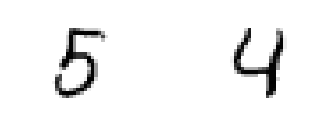

In [35]:
for i, image in enumerate([image1, image2]):
    plt.subplot(2, 2, i + 1)
    plt.axis('off')
    plt.imshow((np.reshape(image, (28, 28)) * 255).astype(np.uint8), cmap=plt.cm.gray_r, interpolation='nearest')

**Tip**: If plot fails please upgrade dask library.

!pip install dask --upgrade

Build scoring dictionary consisting of two digits and send it to deployed model to get predictions.

In [36]:
scoring_data = {"values": [image1, image2]}

In [37]:
predictions = client.deployments.score(scoring_url, scoring_data)
print("Scoring result: " + str(predictions))

Scoring result: {'values': [8, 9]}


<HR>

<a id="summary"></a>
## 7. Summary and next steps     

 You successfully completed this notebook! You learned how to use `watson-machine-learning-client` to run experiments. Check out our _[Online Documentation](https://dataplatform.ibm.com/docs/content/analyze-data/wml-ai.html?context=analytics)_ for more samples, tutorials, documentation, how-tos, and blog posts. 

### Authors

**Wojciech Sobala**, Data Scientist in IBM working on Watson Machine Learning service (public Cloud).

**Lukasz Cmielowski**, PhD, is a Automation Architect and Data Scientist in IBM with a track record of developing enterprise-level applications that substantially increases clients' ability to turn data into actionable knowledge.



Copyright © 2017 IBM. This notebook and its source code are released under the terms of the MIT License.